# Generalized Hyperbolic (GH) Distribution

The Generalized Hyperbolic distribution is the most general form of the normal variance-mean mixture family.

## Definition

A random variable $X$ follows a Generalized Hyperbolic distribution if it can be written as:

$$X = \mu + \gamma Y + \sqrt{Y} Z$$

where:
- $Z \sim N(0, \Sigma)$ is independent of $Y$
- $Y \sim \text{GIG}(p, a, b)$ (Generalized Inverse Gaussian)

## Special Cases

| Distribution | GIG Parameters | Mixing Distribution |
|-------------|---------------|--------------------|
| **Variance Gamma** | $b \to 0$, $p > 0$ | Gamma$(p, a/2)$ |
| **Normal-Inverse Gaussian** | $p = -1/2$ | InverseGaussian$(\delta, \eta)$ |
| **Normal-Inverse Gamma** | $a \to 0$, $p < 0$ | InverseGamma$(-p, b/2)$ |
| **Hyperbolic** | $p = 1$ | GIG$(1, a, b)$ |

## Key Properties

- **Joint distribution** $f(x, y)$ is an **exponential family**
- **Marginal distribution** $f(x)$ is **NOT** an exponential family
- Fitting uses the **EM algorithm** with **parameter regularization**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats

from normix.distributions.mixtures import (
    GeneralizedHyperbolic, JointGeneralizedHyperbolic,
    VarianceGamma, NormalInverseGaussian, NormalInverseGamma
)
from normix.utils import (
    plot_joint_distribution_1d, plot_marginal_distribution_2d,
    validate_moments, print_moment_validation,
    fit_and_track_convergence, plot_em_convergence,
    test_joint_fitting, print_fitting_results
)

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("Imports successful!")

Imports successful!


---
## 1. Joint Distribution: $f(x, y)$ (Exponential Family)

The joint distribution is:

$$f(x, y) = f(x|y) \cdot f(y)$$

where:
- $X|Y \sim N(\mu + \gamma Y, \Sigma Y)$
- $Y \sim \text{GIG}(p, a, b)$

In [2]:
# Define parameters for 1D joint distribution
params_1d = {
    'mu': np.array([0.0]),
    'gamma': np.array([0.5]),
    'sigma': np.array([[1.0]]),
    'p': 1.0,
    'a': 1.0,
    'b': 1.0
}

# Create joint distribution
jgh_1d = JointGeneralizedHyperbolic.from_classical_params(**params_1d)
print("Created:", jgh_1d)
print("\nClassical parameters:", jgh_1d.classical_params)

Created: JointGeneralizedHyperbolic(μ=0.000, γ=0.500, p=1.000, a=1.000, b=1.000)

Classical parameters: GHParams(mu=array([0.]), gamma=array([0.5]), sigma=array([[1.]]), p=np.float64(1.0), a=np.float64(1.0), b=np.float64(1.0))


/tmp/ipykernel_2346057/2167798511.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


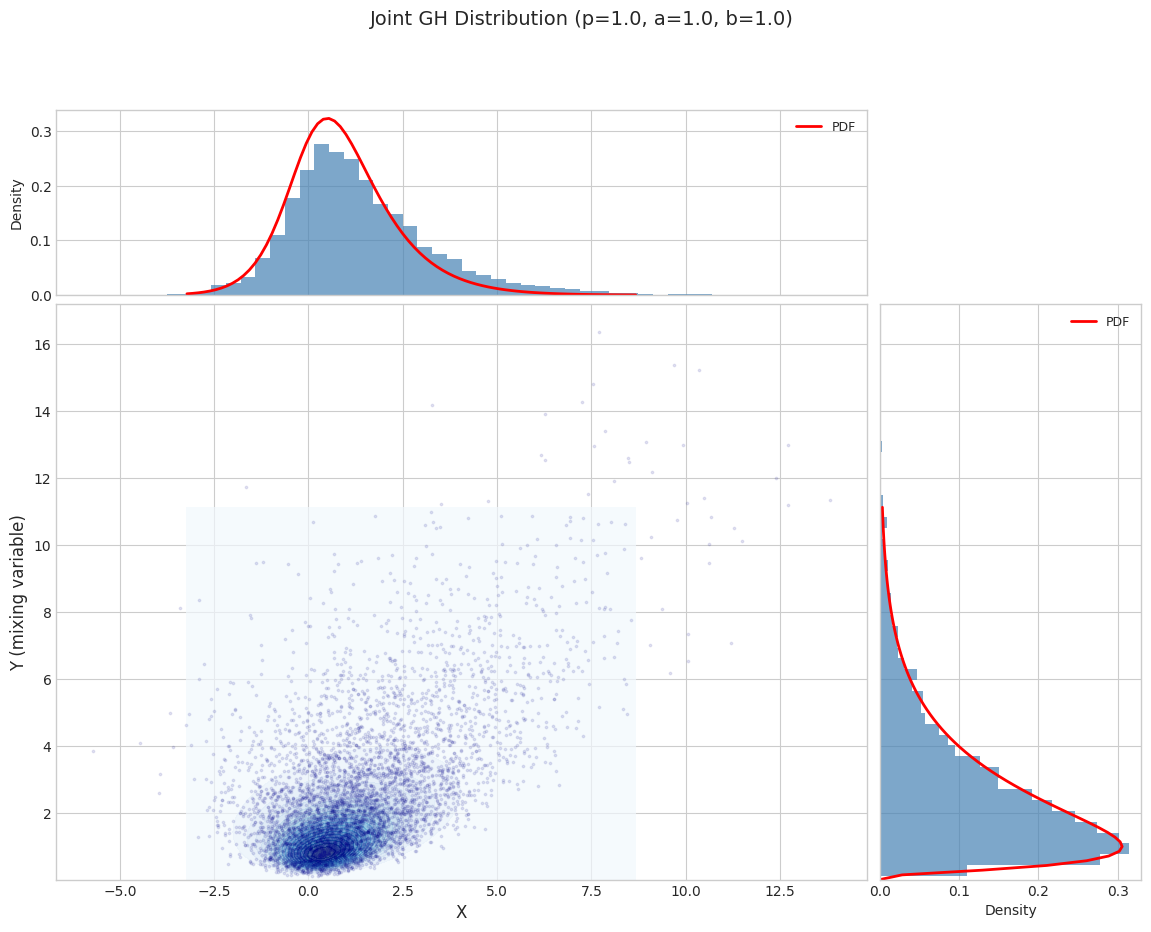

In [3]:
# Visualize joint distribution
fig = plot_joint_distribution_1d(
    jgh_1d, n_samples=5000, random_state=42,
    title=f"Joint GH Distribution (p={params_1d['p']}, a={params_1d['a']}, b={params_1d['b']})"
)
plt.tight_layout()
plt.show()

### 1.1 Moment Validation

In [4]:
# Validate moments
moment_results = validate_moments(jgh_1d, n_samples=20000, random_state=42, is_joint=True)
print_moment_validation(moment_results)


Moment Validation: Distribution
X_mean    : sample =     1.3374, theory =     1.3497, rel_err = 9.18e-03
Y_mean    : sample =     2.7129, theory =     2.6995, rel_err = 4.98e-03
X_var     : sample =     3.8364, theory =     3.8272, rel_err = 2.43e-03
Y_var     : sample =     4.5105, theory =     4.5107, rel_err = 5.71e-05


### 1.2 MLE Fitting (Complete Data)

In [5]:
# Test MLE fitting for joint distribution
fitted_dist, fitted_params, param_errors = test_joint_fitting(
    JointGeneralizedHyperbolic,
    params_1d,
    n_samples=10000,
    random_state=42
)
print_fitting_results(params_1d, fitted_params, param_errors, name="JointGH")


Fitting Results: JointGH
Parameter                  True          Fitted    Rel.Error
------------------------------------------------------------
mu                       0.0000         -0.0110     1.10e+08
gamma                    0.5000          0.5025     5.00e-03
sigma                    1.0000          1.0071     7.11e-03
p                        1.0000          0.9702     2.98e-02
a                        1.0000          0.9982     1.76e-03
b                        1.0000          1.0471     4.71e-02


---
## 2. Marginal Distribution: $f(x)$ (2D Case)

The marginal distribution is NOT an exponential family.

In [6]:
# Define 2D marginal distribution parameters
params_2d = {
    'mu': np.array([0.0, 0.0]),
    'gamma': np.array([0.5, -0.3]),
    'sigma': np.array([[1.0, 0.3], [0.3, 1.0]]),
    'p': 1.0,
    'a': 1.0,
    'b': 1.0
}

# Create marginal distribution
gh_2d = GeneralizedHyperbolic.from_classical_params(**params_2d)
print("Created:", gh_2d)

Created: GeneralizedHyperbolic(d=2, p=1.000, a=1.000, b=1.000)


/tmp/ipykernel_2346057/2887610028.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


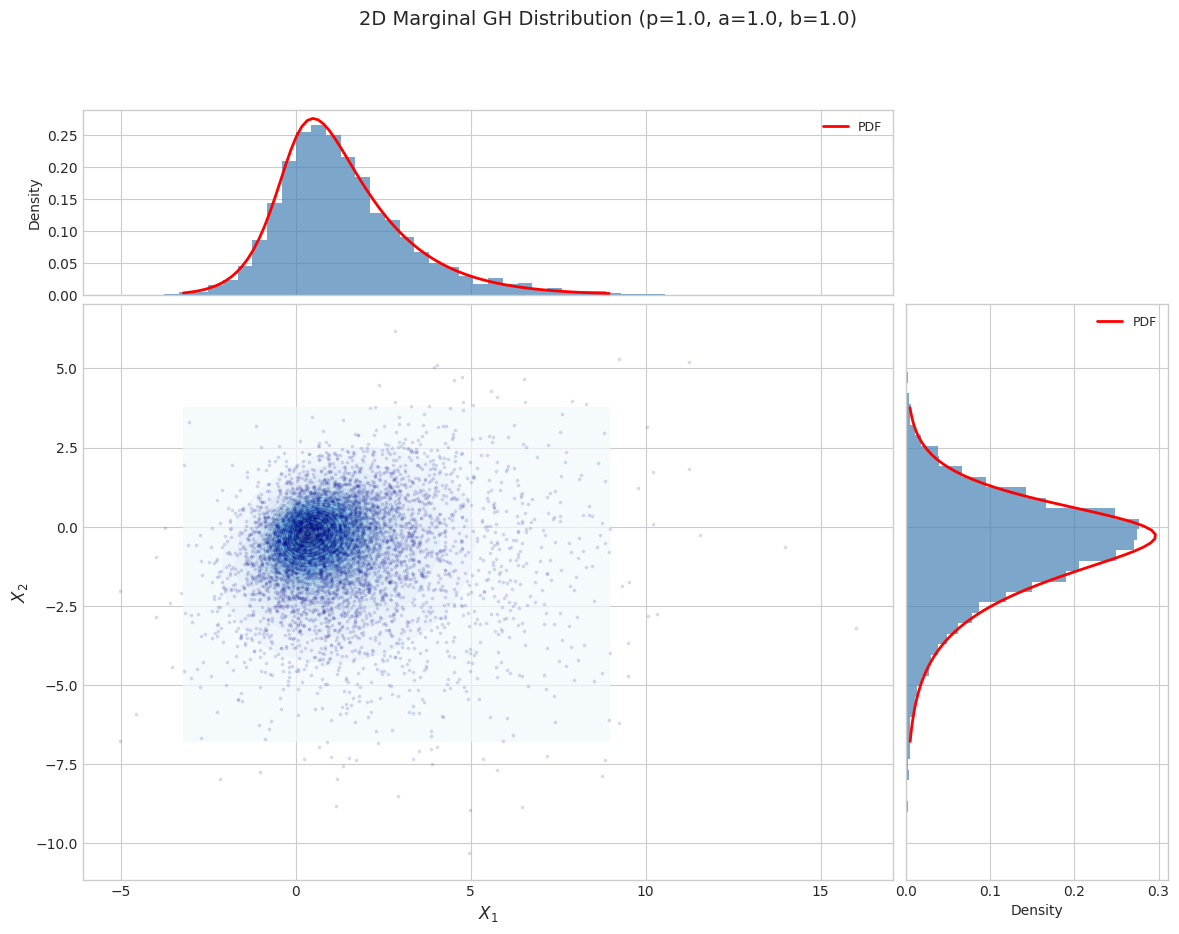

In [7]:
# Visualize 2D marginal distribution
fig = plot_marginal_distribution_2d(
    gh_2d, n_samples=5000, random_state=42,
    title=f"2D Marginal GH Distribution (p={params_2d['p']}, a={params_2d['a']}, b={params_2d['b']})"
)
plt.tight_layout()
plt.show()

### 2.1 EM Algorithm Fitting

The marginal distribution requires the EM algorithm for fitting.

In [17]:
# Generate data from true distribution
true_gh = GeneralizedHyperbolic.from_classical_params(**params_2d)
X_data = true_gh.rvs(size=5000, random_state=42)

# Compute true log-likelihood for reference
true_ll = np.mean(true_gh.logpdf(X_data))
print(f"True parameters log-likelihood: {true_ll:.4f}")

# Fit using EM algorithm with regularization
print("\nFitting with EM algorithm (det_sigma_one regularization)...")
fitted_gh, convergence = fit_and_track_convergence(
    GeneralizedHyperbolic,
    X_data,
    max_iter=100,
    tol=1e-2,  # Use reasonable tolerance for GH
    regularization='det_sigma_one',
)

print(f"\nConverged: {convergence.converged}")
print(f"Final log-likelihood: {convergence.log_likelihoods[-1]:.4f}")
print(f"Improvement over true: {convergence.log_likelihoods[-1] - true_ll:.4f}")

True parameters log-likelihood: -3.8839

Fitting with EM algorithm (det_sigma_one regularization)...

Converged: True
Final log-likelihood: -3.8824
Improvement over true: 0.0015


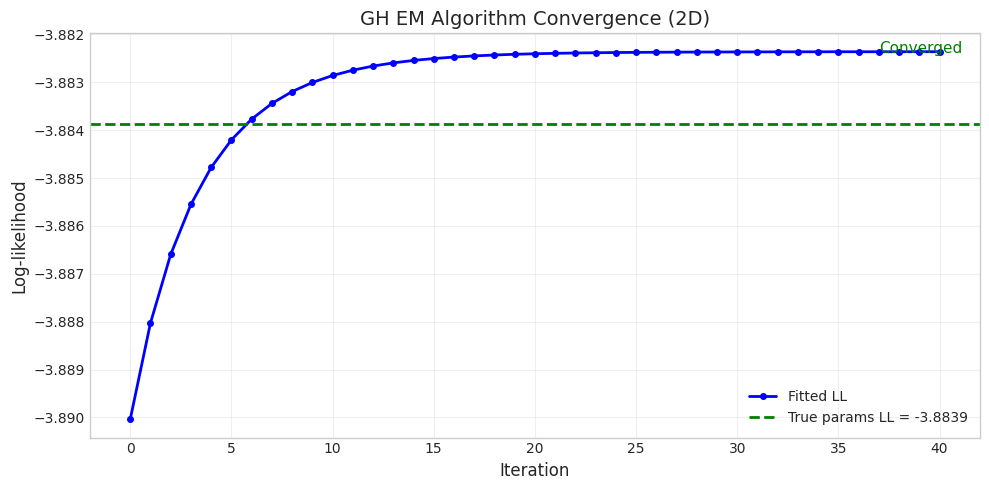

In [18]:
# Plot convergence with true log-likelihood reference
fig = plot_em_convergence(
    convergence, 
    title="GH EM Algorithm Convergence (2D)",
    true_ll=true_ll
)
plt.show()

---
## 3. Effect of GIG Parameters

The GIG parameters $(p, a, b)$ control the shape of the mixing distribution and thus the behavior of the GH distribution.

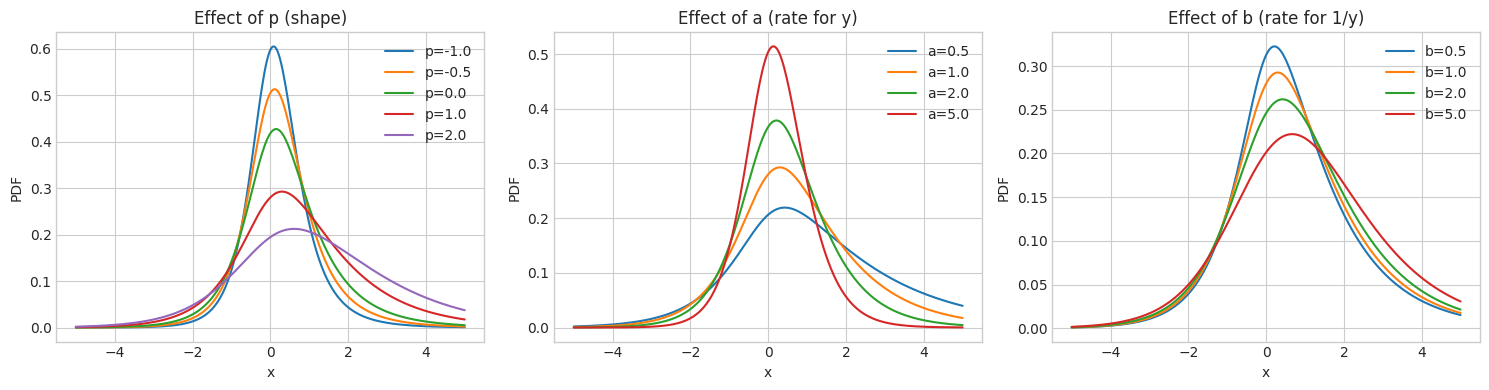

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Base parameters
base_mu = np.array([0.0])
base_gamma = np.array([0.3])
base_sigma = np.array([[1.0]])

x = np.linspace(-5, 5, 300)

# Effect of p
ax = axes[0]
for p in [-1.0, -0.5, 0.0, 1.0, 2.0]:
    try:
        gh = GeneralizedHyperbolic.from_classical_params(
            mu=base_mu, gamma=base_gamma, sigma=base_sigma, p=p, a=1.0, b=1.0
        )
        pdf = np.array([gh.pdf(np.array([xi])) for xi in x])
        ax.plot(x, pdf, label=f'p={p}')
    except:
        pass
ax.set_title('Effect of p (shape)')
ax.set_xlabel('x')
ax.set_ylabel('PDF')
ax.legend()

# Effect of a
ax = axes[1]
for a in [0.5, 1.0, 2.0, 5.0]:
    try:
        gh = GeneralizedHyperbolic.from_classical_params(
            mu=base_mu, gamma=base_gamma, sigma=base_sigma, p=1.0, a=a, b=1.0
        )
        pdf = np.array([gh.pdf(np.array([xi])) for xi in x])
        ax.plot(x, pdf, label=f'a={a}')
    except:
        pass
ax.set_title('Effect of a (rate for y)')
ax.set_xlabel('x')
ax.set_ylabel('PDF')
ax.legend()

# Effect of b
ax = axes[2]
for b in [0.5, 1.0, 2.0, 5.0]:
    try:
        gh = GeneralizedHyperbolic.from_classical_params(
            mu=base_mu, gamma=base_gamma, sigma=base_sigma, p=1.0, a=1.0, b=b
        )
        pdf = np.array([gh.pdf(np.array([xi])) for xi in x])
        ax.plot(x, pdf, label=f'b={b}')
    except:
        pass
ax.set_title('Effect of b (rate for 1/y)')
ax.set_xlabel('x')
ax.set_ylabel('PDF')
ax.legend()

plt.tight_layout()
plt.show()

---
## 4. Special Case Comparison

Verify that GH special cases match their dedicated implementations.

NIG mean: [0.5], GH mean: [0.5]
NInvG mean: [0.25], GH mean: [0.25]
VG mean: [1.], GH mean: [1.]


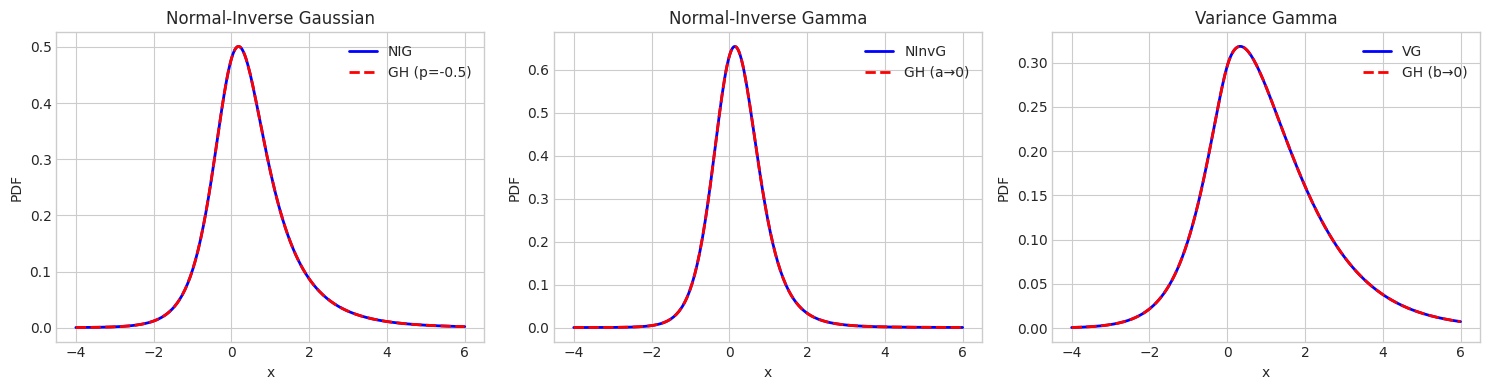

In [11]:
# Test parameters
mu = np.array([0.0])
gamma = np.array([0.5])
sigma = np.array([[1.0]])

x = np.linspace(-4, 6, 300)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# NIG comparison (p = -0.5)
ax = axes[0]
nig_params = {'delta': 1.0, 'eta': 1.0}
nig = NormalInverseGaussian.from_classical_params(mu=mu, gamma=gamma, sigma=sigma, **nig_params)
gh_nig = GeneralizedHyperbolic.as_normal_inverse_gaussian(mu=mu, gamma=gamma, sigma=sigma, **nig_params)

nig_pdf = np.array([nig.pdf(np.array([xi])) for xi in x])
gh_nig_pdf = np.array([gh_nig.pdf(np.array([xi])) for xi in x])

ax.plot(x, nig_pdf, 'b-', linewidth=2, label='NIG')
ax.plot(x, gh_nig_pdf, 'r--', linewidth=2, label='GH (p=-0.5)')
ax.set_title('Normal-Inverse Gaussian')
ax.set_xlabel('x')
ax.set_ylabel('PDF')
ax.legend()
print(f"NIG mean: {nig.mean()}, GH mean: {gh_nig.mean()}")

# NInvG comparison (a → 0)
ax = axes[1]
ninvg_params = {'shape': 3.0, 'rate': 1.0}
ninvg = NormalInverseGamma.from_classical_params(mu=mu, gamma=gamma, sigma=sigma, **ninvg_params)
gh_ninvg = GeneralizedHyperbolic.as_normal_inverse_gamma(mu=mu, gamma=gamma, sigma=sigma, **ninvg_params)

ninvg_pdf = np.array([ninvg.pdf(np.array([xi])) for xi in x])
gh_ninvg_pdf = np.array([gh_ninvg.pdf(np.array([xi])) for xi in x])

ax.plot(x, ninvg_pdf, 'b-', linewidth=2, label='NInvG')
ax.plot(x, gh_ninvg_pdf, 'r--', linewidth=2, label='GH (a→0)')
ax.set_title('Normal-Inverse Gamma')
ax.set_xlabel('x')
ax.set_ylabel('PDF')
ax.legend()
print(f"NInvG mean: {ninvg.mean()}, GH mean: {gh_ninvg.mean()}")

# VG comparison (b → 0)
ax = axes[2]
vg_params = {'shape': 2.0, 'rate': 1.0}
vg = VarianceGamma.from_classical_params(mu=mu, gamma=gamma, sigma=sigma, **vg_params)
gh_vg = GeneralizedHyperbolic.as_variance_gamma(mu=mu, gamma=gamma, sigma=sigma, **vg_params)

vg_pdf = np.array([vg.pdf(np.array([xi])) for xi in x])
gh_vg_pdf = np.array([gh_vg.pdf(np.array([xi])) for xi in x])

ax.plot(x, vg_pdf, 'b-', linewidth=2, label='VG')
ax.plot(x, gh_vg_pdf, 'r--', linewidth=2, label='GH (b→0)')
ax.set_title('Variance Gamma')
ax.set_xlabel('x')
ax.set_ylabel('PDF')
ax.legend()
print(f"VG mean: {vg.mean()}, GH mean: {gh_vg.mean()}")

plt.tight_layout()
plt.show()

---
## 5. Parameter Regularization

The GH model is not identifiable since $(\mu, \gamma/c, \Sigma/c, p, cb, a/c)$ gives the same distribution for any $c > 0$.

Available regularization methods:
- `det_sigma_one`: Fix $|\Sigma| = 1$ (recommended)
- `sigma_diagonal_one`: Fix $\Sigma_{11} = 1$
- `fix_p`: Fix $p$ to a specific value
- `none`: No regularization

In [12]:
from normix.distributions.mixtures import REGULARIZATION_METHODS

print("Available regularization methods:")
for name in REGULARIZATION_METHODS:
    print(f"  - {name}")

Available regularization methods:
  - det_sigma_one
  - sigma_diagonal_one
  - fix_p
  - none


In [13]:
# Compare different regularizations
X_data = true_gh.rvs(size=3000, random_state=42)

regularizations = ['det_sigma_one', 'fix_p']
results = {}

for reg in regularizations:
    print(f"\n--- Regularization: {reg} ---")
    fitted = GeneralizedHyperbolic()
    kwargs = {'regularization': reg}
    if reg == 'fix_p':
        kwargs['regularization_params'] = {'p_fixed': 1.0}
    
    fitted.fit(X_data, max_iter=30, verbose=0, **kwargs)
    params = fitted.classical_params
    
    print(f"  p = {params.p:.4f}")
    print(f"  a = {params.a:.4f}")
    print(f"  b = {params.b:.4f}")
    print(f"  |Σ| = {np.linalg.det(params.sigma):.4f}")
    print(f"  Mean = {fitted.mean()}")
    results[reg] = fitted


--- Regularization: det_sigma_one ---


  p = 0.5896
  a = 0.9347
  b = 1.6064
  |Σ| = 1.0000
  Mean = [ 1.27654667 -0.82581383]

--- Regularization: fix_p ---
  p = 1.0000
  a = 0.3575
  b = 14.3831
  |Σ| = 0.0738
  Mean = [ 1.58034717 -1.01797886]


---
## 6. Exponential Family Structure

The joint distribution is an exponential family with:

**Sufficient statistics:**
$$t(x, y) = [\log y, y^{-1}, y, x, xy^{-1}, \text{vec}(xx^T y^{-1})]$$

**Natural parameters:**
$$\theta = [p - 1 - d/2, -(b + \frac{1}{2}\mu^T\Lambda\mu), -(a + \frac{1}{2}\gamma^T\Lambda\gamma), \Lambda\gamma, \Lambda\mu, -\frac{1}{2}\text{vec}(\Lambda)]$$

In [15]:
# Show parameter conversions
print("=== Exponential Family Parameters ===")
print(f"\nClassical: {jgh_1d.classical_params}")
print(f"\nNatural: {jgh_1d.natural_params}")
print(f"\nExpectation: {jgh_1d.expectation_params[:6]}...")  # First 6 components

=== Exponential Family Parameters ===

Classical: GHParams(mu=array([0.]), gamma=array([0.5]), sigma=array([[1.]]), p=np.float64(1.0), a=np.float64(1.0), b=np.float64(1.0))

Natural: [-0.5   -1.    -1.125  0.5    0.    -0.5  ]

Expectation: [0.69948394 0.69948394 2.69948394 1.34974197 0.5        1.67487098]...


In [16]:
# Verify sufficient statistics match expectation parameters
n_samples = 20000
X, Y = jgh_1d.rvs(size=n_samples, random_state=42)
t_samples = jgh_1d._sufficient_statistics(X, Y)
eta_sample = np.mean(t_samples, axis=0)
eta_theory = jgh_1d.expectation_params

print("E[t(X,Y)] from samples vs theoretical:")
print(f"  E[log Y]:     {eta_sample[0]:.4f} vs {eta_theory[0]:.4f}")
print(f"  E[1/Y]:       {eta_sample[1]:.4f} vs {eta_theory[1]:.4f}")
print(f"  E[Y]:         {eta_sample[2]:.4f} vs {eta_theory[2]:.4f}")

E[t(X,Y)] from samples vs theoretical:
  E[log Y]:     0.7052 vs 0.6995
  E[1/Y]:       0.6942 vs 0.6995
  E[Y]:         2.7129 vs 2.6995


---
## Summary

The Generalized Hyperbolic distribution:

1. **Most general** normal variance-mean mixture
2. **Joint** distribution is an exponential family
3. **Marginal** distribution requires EM algorithm for fitting
4. **Special cases** include VG, NIG, NInvG, and more
5. **Regularization** is needed due to identifiability issues